In [8]:
from __future__ import division, print_function
from keras.layers.core import Dense
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import math
import os

In [9]:
DATA_DIR = "data/"

In [10]:
data = np.load(os.path.join(DATA_DIR, "LD_250.npy"))

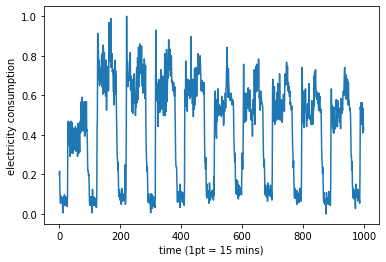

In [19]:
NUM_ENTRIES = 1000
plt.plot(range(len(data)), data)
plt.ylabel("electricity consumption")
plt.xlabel("time (1pt = 15 mins)")
plt.show()

#np.save(os.path.join(DATA_DIR, "LD_250.npy"), np.array(data))

Видна суточная периодичность, так что имеет смысл взять BATCH_SIZE равным 96 (24 часа).

In [29]:
#STATELESS = False

NUM_TIMESTEPS = 20
HIDDEN_SIZE = 10
BATCH_SIZE = 96  # 24 hours (15 min intervals)
NUM_EPOCHS = 100

In [12]:
data = data.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1), copy=False)
data = scaler.fit_transform(data)

In [13]:
data

array([[0.19939675],
       [0.21560918],
       [0.12393623],
       [0.07007433],
       [0.0538619 ],
       [0.09161909],
       [0.08084671],
       [0.06468814],
       [0.05930195],
       [0.08084671],
       [0.06468814],
       [0.02693095],
       [0.00538619],
       [0.0862329 ],
       [0.07546052],
       [0.04847571],
       [0.04308952],
       [0.09700528],
       [0.07007433],
       [0.04847571],
       [0.04308952],
       [0.0862329 ],
       [0.06468814],
       [0.0538619 ],
       [0.0538619 ],
       [0.04308952],
       [0.03770333],
       [0.0862329 ],
       [0.38807498],
       [0.46892168],
       [0.3773026 ],
       [0.3773026 ],
       [0.46353549],
       [0.3449316 ],
       [0.3449316 ],
       [0.44737693],
       [0.2910697 ],
       [0.38807498],
       [0.46892168],
       [0.31800065],
       [0.37191641],
       [0.46353549],
       [0.30722827],
       [0.37191641],
       [0.43655068],
       [0.30722827],
       [0.35031779],
       [0.425

При обработке каждого пакета модель принимает последовательность 15-минутных отсчетов и предсказывает следующий. Длина входной последовательности определяется переменной num_timesteps (пусть равно 20). То есть длина входной последовательности будет равна 20, а выходной 1.

In [14]:
X = np.zeros((data.shape[0], NUM_TIMESTEPS))
Y = np.zeros((data.shape[0], 1))
for i in range(len(data) - NUM_TIMESTEPS - 1):
    X[i] = data[i:i + NUM_TIMESTEPS].T
    Y[i] = data[i + NUM_TIMESTEPS + 1]

In [15]:
X

array([[0.19939675, 0.21560918, 0.12393623, ..., 0.09700528, 0.07007433,
        0.04847571],
       [0.21560918, 0.12393623, 0.07007433, ..., 0.07007433, 0.04847571,
        0.04308952],
       [0.12393623, 0.07007433, 0.0538619 , ..., 0.04847571, 0.04308952,
        0.0862329 ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [16]:
Y

array([[0.0862329 ],
       [0.06468814],
       [0.0538619 ],
       [0.0538619 ],
       [0.04308952],
       [0.03770333],
       [0.0862329 ],
       [0.38807498],
       [0.46892168],
       [0.3773026 ],
       [0.3773026 ],
       [0.46353549],
       [0.3449316 ],
       [0.3449316 ],
       [0.44737693],
       [0.2910697 ],
       [0.38807498],
       [0.46892168],
       [0.31800065],
       [0.37191641],
       [0.46353549],
       [0.30722827],
       [0.37191641],
       [0.43655068],
       [0.30722827],
       [0.35031779],
       [0.4257783 ],
       [0.32338684],
       [0.36653022],
       [0.43116449],
       [0.3449316 ],
       [0.33415922],
       [0.44199074],
       [0.31800065],
       [0.33415922],
       [0.43116449],
       [0.31800065],
       [0.32338684],
       [0.4257783 ],
       [0.2910697 ],
       [0.33954541],
       [0.45814931],
       [0.36109016],
       [0.30722827],
       [0.44737693],
       [0.35570398],
       [0.31261446],
       [0.431

In [17]:
X.shape

(1000, 20)

In [18]:
Y.shape

(1000, 1)

In [20]:
X = np.expand_dims(X, axis=2)

Измением размерность X на (samples, timesteps, features).

In [21]:
X.shape

(1000, 20, 1)

In [23]:
sp = int(0.7 * len(data))
Xtrain, Xtest, Ytrain, Ytest = X[0:sp], X[sp:], Y[0:sp], Y[sp:]
print(Xtrain.shape, Xtest.shape, Ytrain.shape, Ytest.shape)

(700, 20, 1) (300, 20, 1) (700, 1) (300, 1)


In [30]:
model = Sequential()
model.add(LSTM(HIDDEN_SIZE, input_shape=(NUM_TIMESTEPS, 1), 
               return_sequences=False))
model.add(Dense(1))

In [31]:
model.compile(loss="mean_squared_error", optimizer="adam",
              metrics=["mean_squared_error"])

In [32]:
model.fit(Xtrain, Ytrain, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE,
              validation_data=(Xtest, Ytest),
              shuffle=False)

Train on 700 samples, validate on 300 samples
Epoch 1/100
700/700 [==============================] - 1s 775us/step - loss: 0.2566 - mean_squared_error: 0.2566 - val_loss: 0.1513 - val_mean_squared_error: 0.1513
Epoch 2/100
700/700 [==============================] - 0s 132us/step - loss: 0.1764 - mean_squared_error: 0.1764 - val_loss: 0.0962 - val_mean_squared_error: 0.0962
Epoch 3/100
700/700 [==============================] - 0s 154us/step - loss: 0.1122 - mean_squared_error: 0.1122 - val_loss: 0.0557 - val_mean_squared_error: 0.0557
Epoch 4/100
700/700 [==============================] - 0s 138us/step - loss: 0.0665 - mean_squared_error: 0.0665 - val_loss: 0.0339 - val_mean_squared_error: 0.0339
Epoch 5/100
700/700 [==============================] - 0s 135us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0315 - val_mean_squared_error: 0.0315
Epoch 6/100
700/700 [==============================] - 0s 124us/step - loss: 0.0404 - mean_squared_error: 0.0404 - val_loss: 0.03

700/700 [==============================] - 0s 126us/step - loss: 0.0175 - mean_squared_error: 0.0175 - val_loss: 0.0129 - val_mean_squared_error: 0.0129
Epoch 51/100
700/700 [==============================] - 0s 122us/step - loss: 0.0173 - mean_squared_error: 0.0173 - val_loss: 0.0127 - val_mean_squared_error: 0.0127
Epoch 52/100
700/700 [==============================] - 0s 106us/step - loss: 0.0172 - mean_squared_error: 0.0172 - val_loss: 0.0126 - val_mean_squared_error: 0.0126
Epoch 53/100
700/700 [==============================] - 0s 109us/step - loss: 0.0170 - mean_squared_error: 0.0170 - val_loss: 0.0125 - val_mean_squared_error: 0.0125
Epoch 54/100
700/700 [==============================] - 0s 99us/step - loss: 0.0169 - mean_squared_error: 0.0169 - val_loss: 0.0125 - val_mean_squared_error: 0.0125
Epoch 55/100
700/700 [==============================] - 0s 123us/step - loss: 0.0168 - mean_squared_error: 0.0168 - val_loss: 0.0124 - val_mean_squared_error: 0.0124
Epoch 56/100
700/7

700/700 [==============================] - 0s 126us/step - loss: 0.0149 - mean_squared_error: 0.0149 - val_loss: 0.0115 - val_mean_squared_error: 0.0115
Epoch 100/100
700/700 [==============================] - 0s 119us/step - loss: 0.0149 - mean_squared_error: 0.0149 - val_loss: 0.0115 - val_mean_squared_error: 0.0115


In [33]:
score, _ = model.evaluate(Xtest, Ytest, batch_size=BATCH_SIZE)
rmse = math.sqrt(score)
print("\nMSE: {:.3f}, RMSE: {:.3f}".format(score, rmse))

300/300 [==============================] - 0s 45us/step

MSE: 0.012, RMSE: 0.107


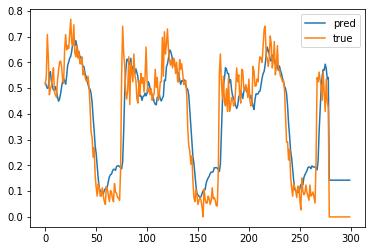

In [44]:
plt.plot(range(len(Ytest)),model.predict(Xtest).reshape(1,-1)[0],label='pred')
plt.plot(range(len(Ytest)),Ytest.reshape(1,-1)[0],label='true')
plt.legend()
plt.show()